# Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import collections
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian
from scipy import integrate
from tqdm.notebook import tqdm

In [6]:
df = pd.read_csv('df_t60.csv')
# Use read_csv function to read .csv file.

df.rename(columns={'Unnamed: 0': 'Original Index'}, inplace=True)
# Rename the column label of the 0th column in place.
df

Original Index  Condition  99.125010  103.636225  108.145260  112.649993  \
0               40          1     4873.0      5582.0      5545.0      5295.0   
1               41          1     5056.0      5414.0      5607.0      5535.0   
2               42          1     4919.0      5530.0      5480.0      5297.0   
3               43          1     4924.0      5344.0      5540.0      5151.0   
4               44          1     4896.0      5323.0      5401.0      5115.0   
..             ...        ...        ...         ...         ...         ...   
85             576          9     6103.0      7073.0      7060.0      6699.0   
86             577          9     6115.0      6993.0      6952.0      6938.0   
87             578          9     6265.0      7097.0      7226.0      6791.0   
88             579          9     6210.0      6808.0      6933.0      6880.0   
89             580          9     6302.0      6941.0      7183.0      6596.0   

    117.152551  121.652937  126.149030  130.640835  ...  2472.950542  \
0       4845.0      4521.0      3963.0      3677.0  ...        175.0   
1       4730.0      4446.0      4027.0      3678.0  ...        216.0   
2       4822.0      4485.0      3873.0      3598.0  ...        167.0   
3       4911.0      4453.0      4033.0      3629.0  ...        188.0   
4       4769.0      4352.0      4111.0      3616.0  ...        140.0   
..         ...         ...         ...         ...  ...          ...   
85      6242.0      5628.0      5092.0      4634.0  ...        127.0   
86      6018.0      5568.0      4906.0      4739.0  ...        125.0   
87      6184.0      5710.0      5139.0      4774.0  ...        174.0   
88      6271.0      5700.0      5136.0      4770.0  ...        144.0   
89      6093.0      5618.0      5088.0      4704.0  ...        123.0   

    2476.113799  2479.274208  2482.435010  2485.594586  2488.751318  \
0         138.0        150.0        170.0        168.0        176.0   
1          97.0        188.0        141.0        169.0        120.0   
2         154.0        161.0        146.0        139.0        210.0   
3         165.0        173.0        145.0        128.0        147.0   
4         109.0        153.0        159.0        156.0        188.0   
..          ...          ...          ...          ...          ...   
85         66.0        143.0        121.0        112.0        112.0   
86         56.0        176.0        115.0        120.0        130.0   
87         79.0        115.0        134.0        124.0        118.0   
88          9.0         61.0         71.0        137.0        116.0   
89         81.0        125.0        150.0        102.0        127.0   

    2491.908444  2495.062729  2498.212560  2501.364402  
0         228.0        175.0        173.0        164.0  
1         221.0        148.0        191.0         90.0  
2         169.0        211.0        165.0        167.0  
3         186.0        186.0        192.0        151.0  
4         181.0        153.0        151.0        100.0  
..          ...          ...          ...          ...  
85        112.0        142.0        127.0         34.0  
86        123.0         88.0        126.0         29.0  
87        135.0        108.0        150.0         68.0  
88        102.0        149.0        127.0         54.0  
89        120.0        140.0        140.0        116.0  

[90 rows x 639 columns]

In [7]:
t60_c2 = df.iloc[10,2:]
t60_c2.to_excel(r'C:\Users\Tan Jin Da\Desktop\High Throughput Experiments Data\2. Data - Consolidated (w_i for MWD)\210419 Waterfall plot for raman excel files\ c2_t60_single_spectra.xlsx')

# Test Plots and Baseline Correction

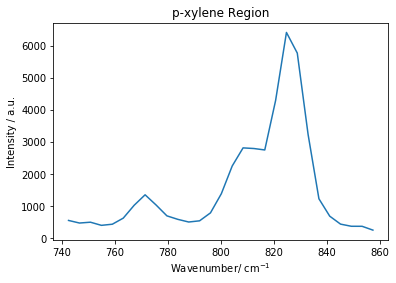

In [3]:
# Extract relevant p-xylene region and Vinyl region from the 1st spectra for
# baseline correction and plot tests.

pxyl_Region = df.iloc[0, 151:180] # Extract 1st spectra at the pxyl region and plot.
pxyl_Region.index = pxyl_Region.index.astype(float) # Change the index type to float.
pxyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
plt.show()

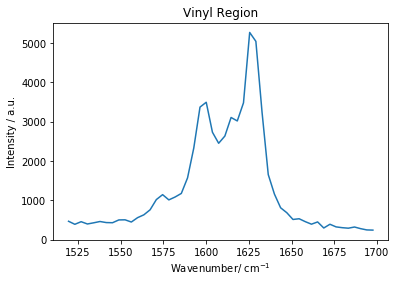

In [4]:
Vinyl_Region = df.iloc[0, 350:400] # Extract 1st spectra at the Vinyl region and plot.
Vinyl_Region.index = Vinyl_Region.index.astype(float) # Change the index type to float.
Vinyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
plt.show()

# Baseline Subtraction

## Custom

Choose two regions on the spectrum that you want to form the basis for the baseline. The spectrum is based on the truncated region of interest from the raw spectrum.

Choose from the curve above, <10 and >50 to form the x and y values to fit a polynomial line, serving as my baseline values. **Note that the x-axis is the placeholder index location of the truncated spectra, not the actual wavenumbers themselves**

p-xylene Region Baseline Subtraction

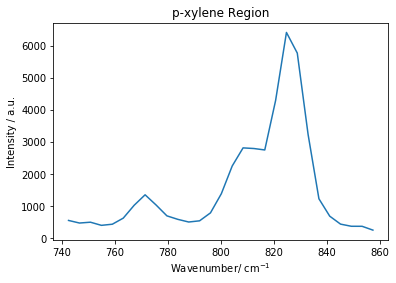

In [5]:
# p-xylene Region Baseline Subtraction
y = df.iloc[0, 151:180]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
y.plot()
plt.show()

# y is a Series. A pandas Series is a lablled/ indexed 1-D array. Therefore, a single argument of y,
# itself containing the intensity value (y-axis) at the corresponding wavenumber (x-axis) can be plotted. 

# Plot the 1st spectra (1st row) of df_t0.

In [6]:
xbl = [] # x-baseline.

for items in y.index[:5].values.tolist():
    xbl.append(items)

for items in y.index[25:].values.tolist():
    xbl.append(items)

# Recall that y is a Series with intensities labelled by their wavenumbers. y.index gives the Series labels, which are the 
# wavenumbers. y.index[:10] gives the 0th to 9th Series labels and is an index object. Convert the index object to a numpy
# array via y.index[:10].values, then put them into a list via y.index[:10].values.tolist().

# There are 2 for loops for the xbl (x baseline) list because you want the 1st 10 wavenumbers, but you also want the last
# wavenumbers from index 40 onwards. In the end, xbl is a single list containing all wavenumbers from index 0 to 9,
# and then from index 40 onwards. The same ideas apply for ybl, except for the fact that ybl contains intensities.

ybl = [] # y-baseline.

for items in y.values[:5].tolist():
    ybl.append(items)

for items in y.values[25:].tolist():
    ybl.append(items)
    
# y is a Pandas Series. Therefore, y.values immediately gives the values witihn that series, which are the intensities.

In [7]:
# Check that the range of xbl and ybl values makes sense.
xbl_and_ybl = list(zip(xbl, ybl))# Zip xbl and ybl together, then use list function to unpack the zipped object.
xbl_and_ybl

[(742.492828, 548.0),
 (746.621203, 467.0),
 (750.74967, 493.0),
 (754.876246, 395.0),
 (758.998952, 430.0),
 (845.036073, 433.0),
 (849.105859, 366.0),
 (853.173798, 365.0),
 (857.23989, 246.0)]

Running the baseline fit. **(x-values, y-values, polynomial degree)** are the arguments.

In [8]:
blpars = np.polyfit(xbl, ybl, 1)
# blpars contains the baseline parameters; the coefficients which will allow for the baseline polynomial to be defined.
# Fit a polynomial based on the x and y-values chosen for the spectra during the previous step. Thus, given a list of x values
# and its corresponding y-values, fit a polynomial through these points as best as you can. This polynomial will serve as the 
# baseline to be subtracted from the spectra's y-values. 
# numpy.polyfit(x, y, deg)
# np.polyfit: Least squares polynomial fit. Fit a polynomial p(x) = p[0] * x**deg + ... + p[deg] of degree deg to points (x, y).
# Returns a vector of coefficients p that minimises the squared error in the order deg, deg-1, … 0.
# Since degree = 1, we are fitting a straight line.

blfit = np.poly1d(blpars)
# A one-dimensional polynomial class. A convenience class, used to encapsulate “natural” operations on polynomials so that
# said operations may take on their customary form in code. blfit is a function that encompasses information on blpar's vector
# of coefficients derived from the np.polyfit step. It will take an input of x-values, then apply the coefficients to the
# x-values to obtain the best fit polynomial following the p(x) equation defined above.

Plot showing before and after subtraction.

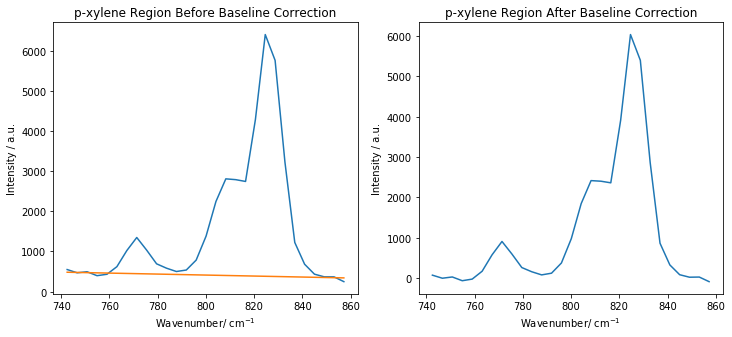

In [9]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1) # subplot(nrows, ncols, index)
plt.plot(y) # Plot the spectrum using the Series y.
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region Before Baseline Correction')
plt.plot(y.index, blfit(y.index))
# Plot the baseline polynomial to be subtracted (orange color). The x-axis will contain the wavenumbers. 
# Therefore y.index(Series labels) is being plotted at the x-axis. The y-axis will be blfit(y.index) because the output of 
# blfit(y.index) contains the y-values of the polynomial that is best fit to the input x-values.

plt.subplot(1,2,2)
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region After Baseline Correction')
plt.plot(y.index,(y - blfit(y.index)))
# Plot the baseline corrected spectrum. Subtraction can immediately be done because blfit(y.index) is a numpy array of y-values
# of the best fit polynomial. So the each value in Series y will minus each value in array blfit(y.index),
# to yield a final y value, which is the corrected spectra intensity. 

plt.show()

Vinyl Region Baseline Subtraction

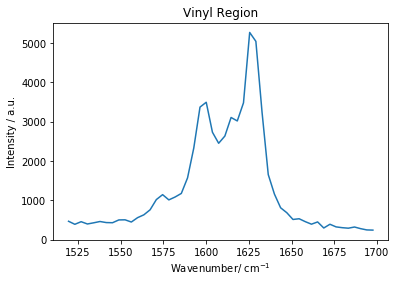

In [10]:
# Vinyl Region Baseline Subtraction
y = df.iloc[0, 350:400]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
y.plot()
plt.show()

In [11]:
xbl = []

for items in y.index[:10].values.tolist():
    xbl.append(items)

for items in y.index[40:].values.tolist():
    xbl.append(items)
    
ybl = []

for items in y.values[:10].tolist():
    ybl.append(items)

for items in y.values[40:].tolist():
    ybl.append(items)

In [12]:
xbl_and_ybl = list(zip(xbl, ybl))
xbl_and_ybl

[(1519.413559, 464.0),
 (1523.101203, 387.0),
 (1526.785456, 453.0),
 (1530.468135, 395.0),
 (1534.149242, 425.0),
 (1537.826964, 458.0),
 (1541.504929, 431.0),
 (1545.179513, 427.0),
 (1548.85072, 498.0),
 (1552.522172, 501.0),
 (1665.287218, 447.0),
 (1668.89313, 293.0),
 (1672.495738, 388.0),
 (1676.098611, 321.0),
 (1679.696401, 301.0),
 (1683.294458, 288.0),
 (1686.88922, 318.0),
 (1690.48247, 276.0),
 (1694.074208, 244.0),
 (1697.664435, 239.0)]

In [13]:
blpars = np.polyfit(xbl, ybl, 1)
blfit = np.poly1d(blpars)

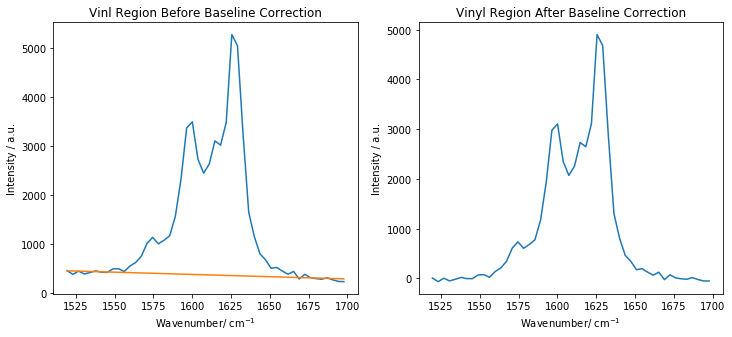

In [14]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.plot(y)
plt.plot(y.index, blfit(y.index))
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinl Region Before Baseline Correction')

plt.subplot(1,2,2)
plt.plot(y.index,(y - blfit(y.index))) 
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region After Baseline Correction')

plt.show()

# Fitting Functions

In [15]:
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian

def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']))
    
    return model - y

# Running Curve Fits

In [16]:
df_vinyl = df.iloc[:, 350:400].copy()
df_vinyl.columns = df_vinyl.columns.astype('float')
df_vinyl

1519.413559  1523.101203  1526.785456  1530.468135  1534.149242  \
0         464.0        387.0        453.0        395.0        425.0   
1         429.0        371.0        406.0        317.0        366.0   
2         461.0        392.0        393.0        379.0        406.0   
3         429.0        369.0        418.0        359.0        346.0   
4         394.0        376.0        443.0        317.0        326.0   
..          ...          ...          ...          ...          ...   
85        276.0        250.0        369.0        260.0        257.0   
86        301.0        280.0        298.0        260.0        234.0   
87        317.0        303.0        343.0        301.0        267.0   
88        280.0        281.0        263.0        312.0        247.0   
89        264.0        278.0        346.0        223.0        245.0   

    1537.826964  1541.504929  1545.179513  1548.850720  1552.522172  ...  \
0         458.0        431.0        427.0        498.0        501.0  ...   
1         415.0        411.0        494.0        489.0        549.0  ...   
2         428.0        462.0        457.0        540.0        429.0  ...   
3         422.0        381.0        421.0        541.0        470.0  ...   
4         397.0        418.0        424.0        531.0        423.0  ...   
..          ...          ...          ...          ...          ...  ...   
85        398.0        343.0        475.0        450.0        475.0  ...   
86        335.0        345.0        444.0        488.0        430.0  ...   
87        364.0        410.0        397.0        543.0        465.0  ...   
88        335.0        342.0        361.0        420.0        457.0  ...   
89        373.0        400.0        420.0        435.0        379.0  ...   

    1665.287218  1668.893130  1672.495738  1676.098611  1679.696401  \
0         447.0        293.0        388.0        321.0        301.0   
1         404.0        320.0        301.0        377.0        262.0   
2         347.0        270.0        331.0        352.0        320.0   
3         335.0        304.0        280.0        345.0        289.0   
4         345.0        256.0        303.0        326.0        303.0   
..          ...          ...          ...          ...          ...   
85        356.0        255.0        239.0        289.0        195.0   
86        338.0        285.0        343.0        296.0        236.0   
87        393.0        319.0        278.0        342.0        221.0   
88        366.0        244.0        254.0        361.0        186.0   
89        333.0        295.0        197.0        307.0        164.0   

    1683.294458  1686.889220  1690.482470  1694.074208  1697.664435  
0         288.0        318.0        276.0        244.0        239.0  
1         274.0        308.0        297.0        204.0        276.0  
2         281.0        325.0        239.0        236.0        232.0  
3         231.0        261.0        299.0        215.0        284.0  
4         244.0        292.0        221.0        193.0        296.0  
..          ...          ...          ...          ...          ...  
85        220.0        241.0        200.0        114.0        158.0  
86        188.0        208.0        222.0        141.0        195.0  
87        202.0        194.0        222.0        123.0        212.0  
88        150.0        200.0        260.0        136.0        203.0  
89        177.0        219.0        259.0        161.0        151.0  

[90 rows x 50 columns]

For 2 Lorentzians peak fits within the region of interest:

## Select initial guess parameters, namely amplitude, centre, width of the peaks.

In [17]:
ampL1 = 140000 # Peak Amplitude of 1st Peak
cenL1 = 1599 # Peak location of 1st Peak
widL1 = 8

ampL2 = 180000 # Peak Amplitude of 2nd Peak
cenL2 = 1627 # Peak location of 2nd Peak
widL2 = 5

## Fitting and Plotting (Vinyl Region)

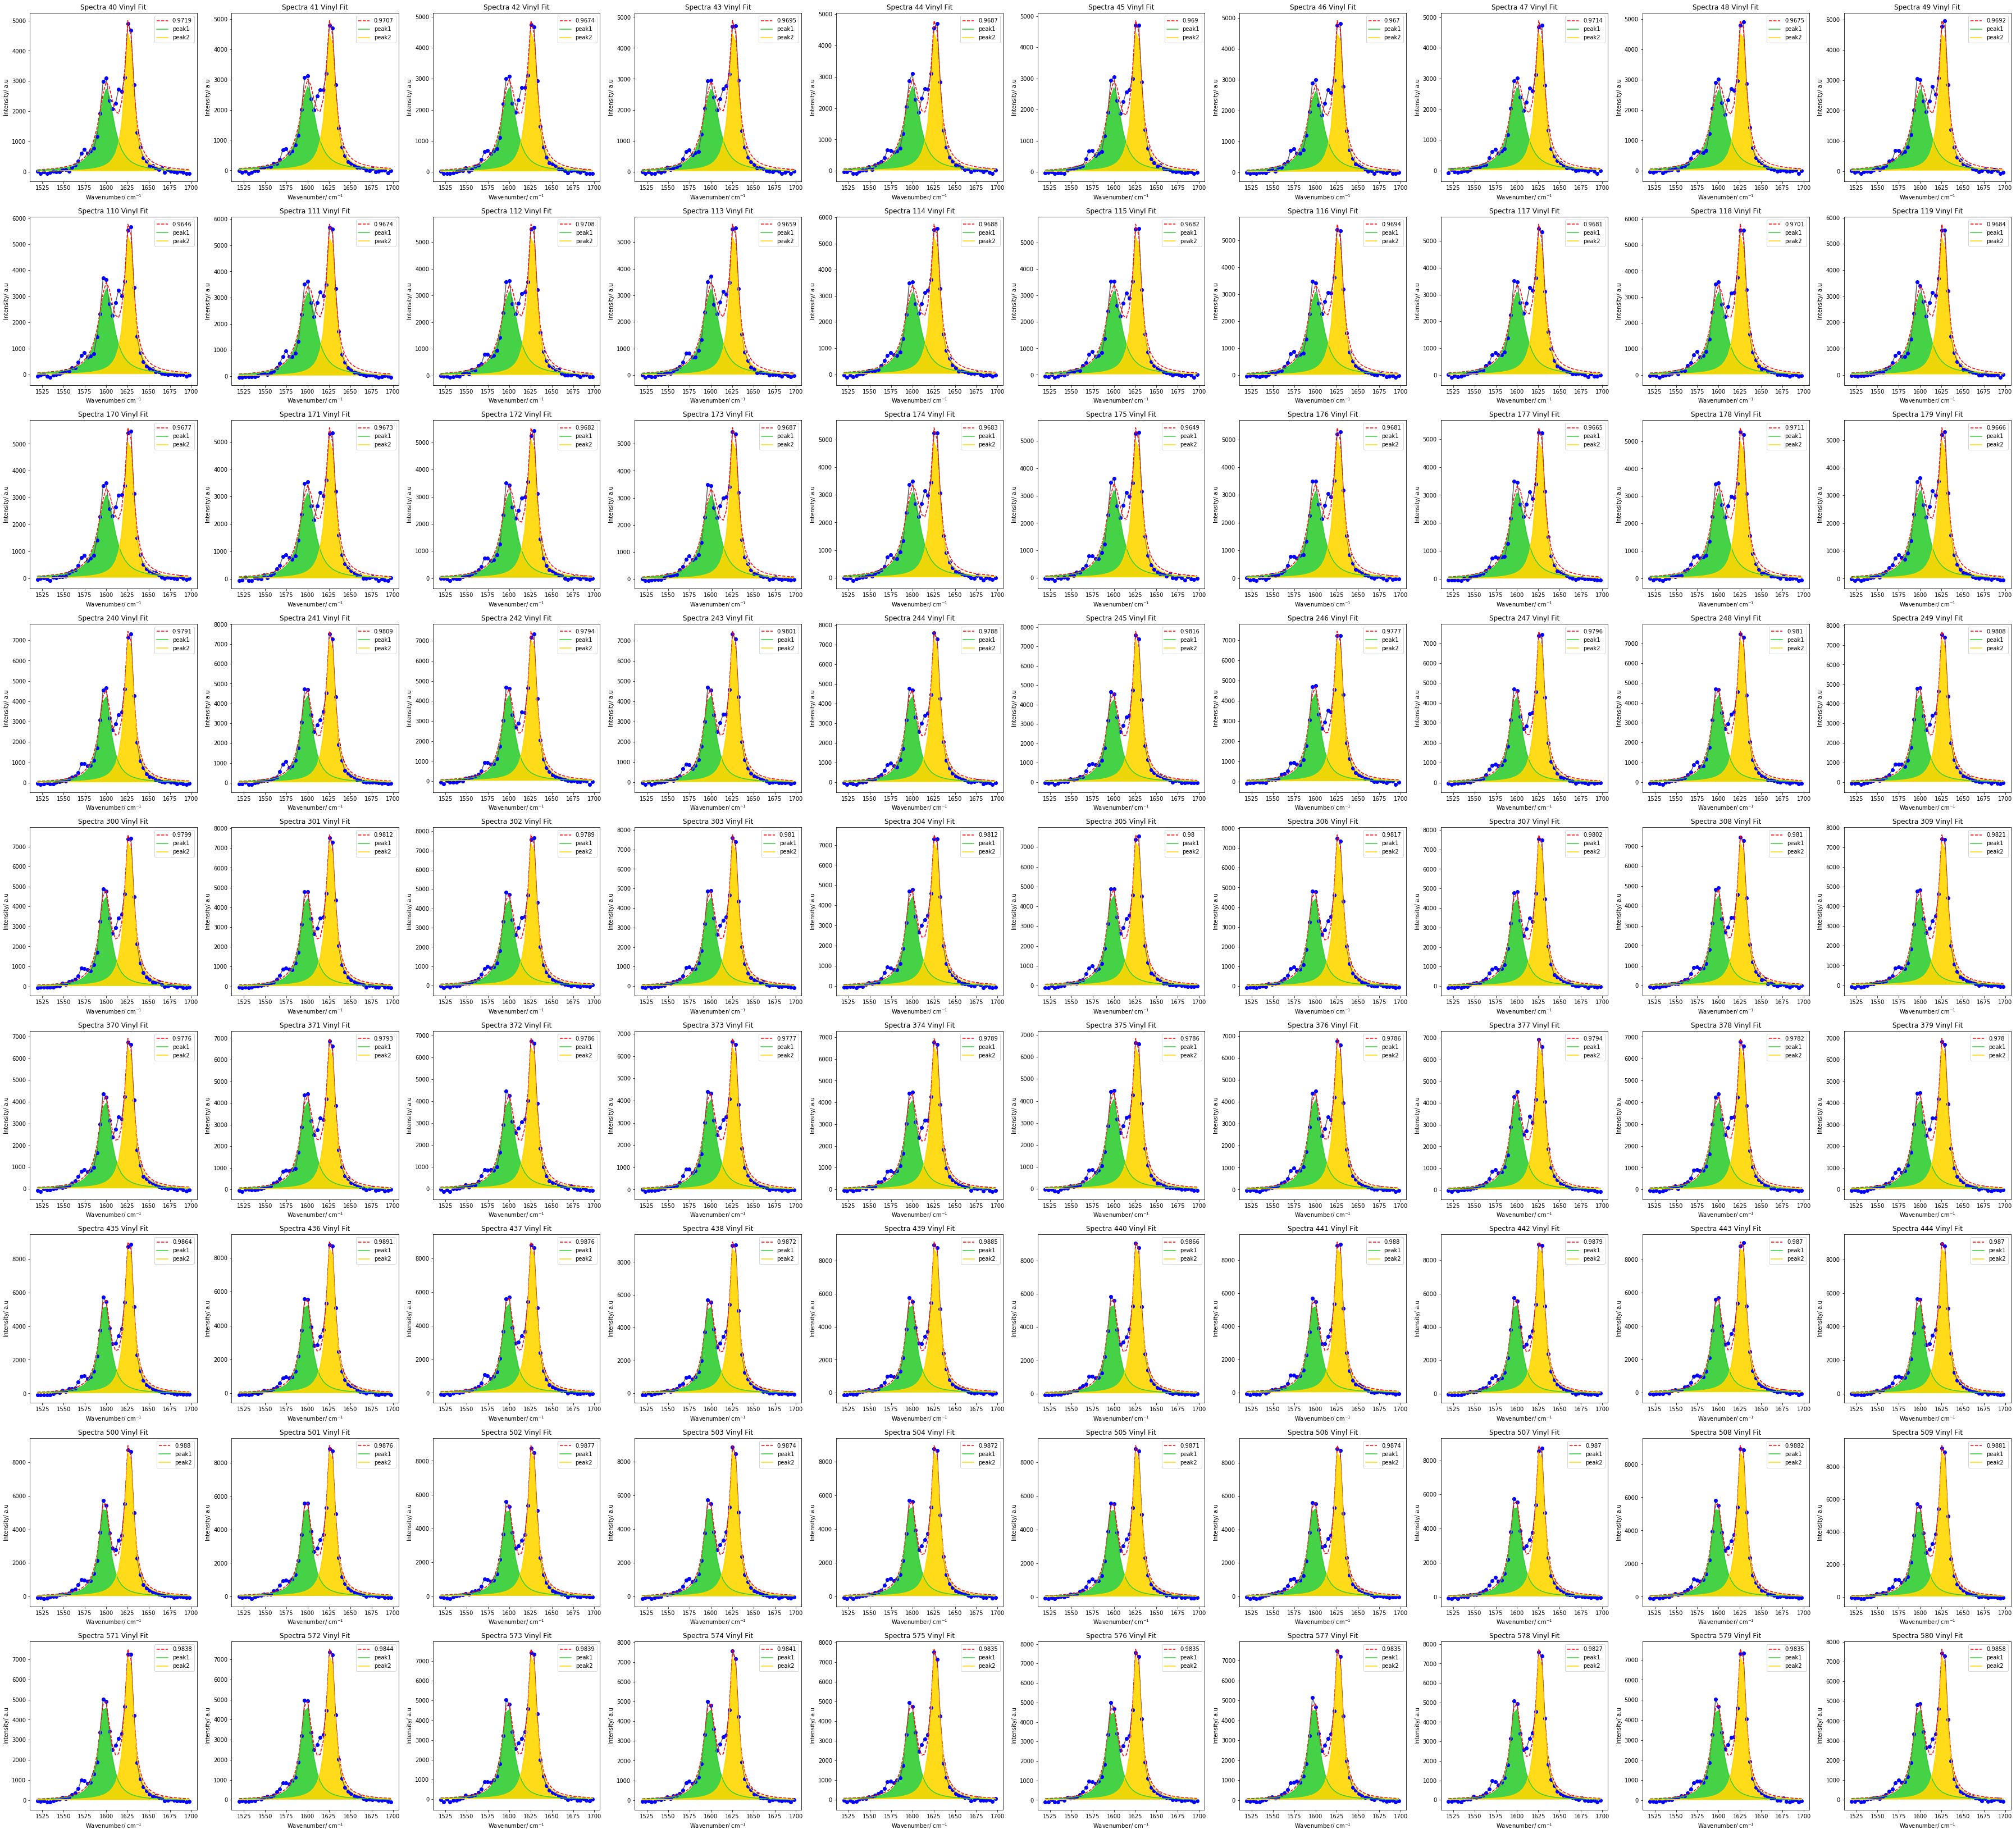

In [18]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])

pbar = tqdm(total = len(df_vinyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='cenL1', value = cenL1, max = 1605)
pfit.add(name='cenL2', value = cenL2, min = 1620, max = 1640)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)

for i,item in df_vinyl.iterrows():
    
    x = df_vinyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:10].values.tolist():
        xbl.append(items)

    for items in y.index[40:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:10].tolist():
        ybl.append(items)

    for items in y.values[40:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['Height_L1'] = 0.3183099*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.3183099*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    
    plt.subplot(np.ceil(np.sqrt(df_vinyl.shape[0])),np.ceil(np.sqrt(df_vinyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' Vinyl Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    
    pbar.update(1)
    
pbar.close()
    
plt.tight_layout()
plt.show()

In [19]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_Vinyl'}, inplace=True)
results.describe()

ampL1          ampL2        cenL1        cenL2      widL1  \
count      90.000000      90.000000    90.000000    90.000000  90.000000   
mean   116363.654804  130314.698393  1599.162122  1626.986901   9.148522   
std     12398.121453   25599.017616     0.774668     0.097383   1.318405   
min     86962.185609   87157.768912  1598.146763  1626.708901   7.607305   
25%    109222.584512  102663.732085  1598.532516  1626.923728   8.018802   
50%    117880.897731  138381.861475  1598.837690  1626.990938   8.636664   
75%    122165.588294  143404.253994  1600.043898  1627.044649  10.584293   
max    136287.573636  166955.938183  1600.578560  1627.209294  11.432583   

           widL2   R2_Vinyl    FWHM_L1    FWHM_L2    Height_L1    Height_L2  
count  90.000000  90.000000  90.000000  90.000000    90.000000    90.000000  
mean    5.857395   0.978141  18.297044  11.714791  4178.090743  7126.057882  
std     0.215770   0.007630   2.636811   0.431540   949.787420  1585.356764  
min     5.495535   0.964649  15.214610  10.991070  2612.578803  4623.960798  
25%     5.685501   0.969399  16.037604  11.371001  3151.824713  5492.023879  
50%     5.841103   0.979498  17.273329  11.682206  4379.467684  7569.997047  
75%     5.964174   0.984051  21.168585  11.928348  4734.020302  7835.508519  
max     6.545784   0.989078  22.865167  13.091567  5538.055709  9576.487576

For 2 Lorentzians peak fits within the region of interest:

In [20]:
Area_2 = pd.Series(Area_2)
labels = df.iloc[:, 0:2]
df_area = pd.concat([labels, Area_2, results['R2_Vinyl']], axis=1)
df_area.rename(columns={0: 'Vinyl Peak Area'}, inplace=True)
df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl
0               40          1     86586.358961  0.971919
1               41          1     87775.613248  0.970677
2               42          1     91638.788868  0.967427
3               43          1     87665.726179  0.969521
4               44          1     85219.916455  0.968660
..             ...        ...              ...       ...
85             576          9    132950.753385  0.983526
86             577          9    133020.366627  0.983495
87             578          9    133455.802634  0.982681
88             579          9    130215.019477  0.983479
89             580          9    130687.853043  0.985839

[90 rows x 4 columns]

# Fitting and Plotting (p-xylene Region)

In [21]:
df_pxyl = df.iloc[:, 151:180].copy()
df_pxyl.columns = df_pxyl.columns.astype('float')
df_pxyl

742.492828  746.621203  750.749670  754.876246  758.998952  763.119771  \
0        548.0       467.0       493.0       395.0       430.0       620.0   
1        565.0       440.0       462.0       408.0       494.0       545.0   
2        599.0       489.0       443.0       395.0       445.0       594.0   
3        578.0       474.0       446.0       397.0       478.0       556.0   
4        534.0       430.0       424.0       389.0       407.0       547.0   
..         ...         ...         ...         ...         ...         ...   
85       617.0       531.0       461.0       442.0       553.0       745.0   
86       598.0       515.0       532.0       402.0       576.0       715.0   
87       584.0       505.0       482.0       522.0       514.0       773.0   
88       584.0       456.0       484.0       504.0       563.0       684.0   
89       498.0       496.0       422.0       473.0       558.0       745.0   

    767.238706  771.353779  775.466971  779.578284  ...  820.560786  \
0       1022.0      1348.0      1032.0       691.0  ...      4293.0   
1        958.0      1281.0      1044.0       579.0  ...      4167.0   
2        992.0      1367.0      1097.0       659.0  ...      4167.0   
3        940.0      1318.0      1020.0       646.0  ...      4180.0   
4        863.0      1276.0      1046.0       748.0  ...      4045.0   
..         ...         ...         ...         ...  ...         ...   
85      1288.0      1834.0      1465.0       899.0  ...      3629.0   
86      1328.0      1989.0      1540.0       864.0  ...      3689.0   
87      1354.0      1879.0      1486.0       870.0  ...      3554.0   
88      1329.0      1824.0      1513.0       880.0  ...      3692.0   
89      1339.0      1810.0      1527.0       929.0  ...      3653.0   

    824.643659  828.726638  832.807761  836.887027  840.962476  845.036073  \
0       6414.0      5770.0      3230.0      1224.0       681.0       433.0   
1       6583.0      5904.0      3042.0      1289.0       638.0       459.0   
2       6565.0      5879.0      2974.0      1243.0       669.0       450.0   
3       6356.0      5718.0      2938.0      1142.0       635.0       391.0   
4       6394.0      5562.0      2985.0      1164.0       658.0       423.0   
..         ...         ...         ...         ...         ...         ...   
85      5551.0      4928.0      2475.0      1114.0       591.0       341.0   
86      5535.0      4883.0      2656.0      1014.0       621.0       417.0   
87      5673.0      4764.0      2595.0      1131.0       556.0       429.0   
88      5601.0      4829.0      2479.0      1001.0       611.0       386.0   
89      5638.0      4922.0      2528.0      1087.0       675.0       398.0   

    849.105859  853.173798  857.239890  
0        366.0       365.0       246.0  
1        415.0       333.0       331.0  
2        398.0       451.0       307.0  
3        383.0       316.0       320.0  
4        371.0       321.0       288.0  
..         ...         ...         ...  
85       351.0       318.0       251.0  
86       387.0       336.0       272.0  
87       362.0       308.0       269.0  
88       314.0       352.0       268.0  
89       336.0       312.0       276.0  

[90 rows x 29 columns]

In [22]:
def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']) +
              split_lorentzian(x, pars['ampL3'], pars['cenL3'], pars['widL3'],pars['widL4']))
    
    return model - y

In [23]:
ampL1 = 20000
cenL1 = 772 
widL1 = 3

ampL2 = 25000 
cenL2 = 808
widL2 = 5

ampL3 = 100000
cenL3 = 826
widL3 = 6
widL4 = 4

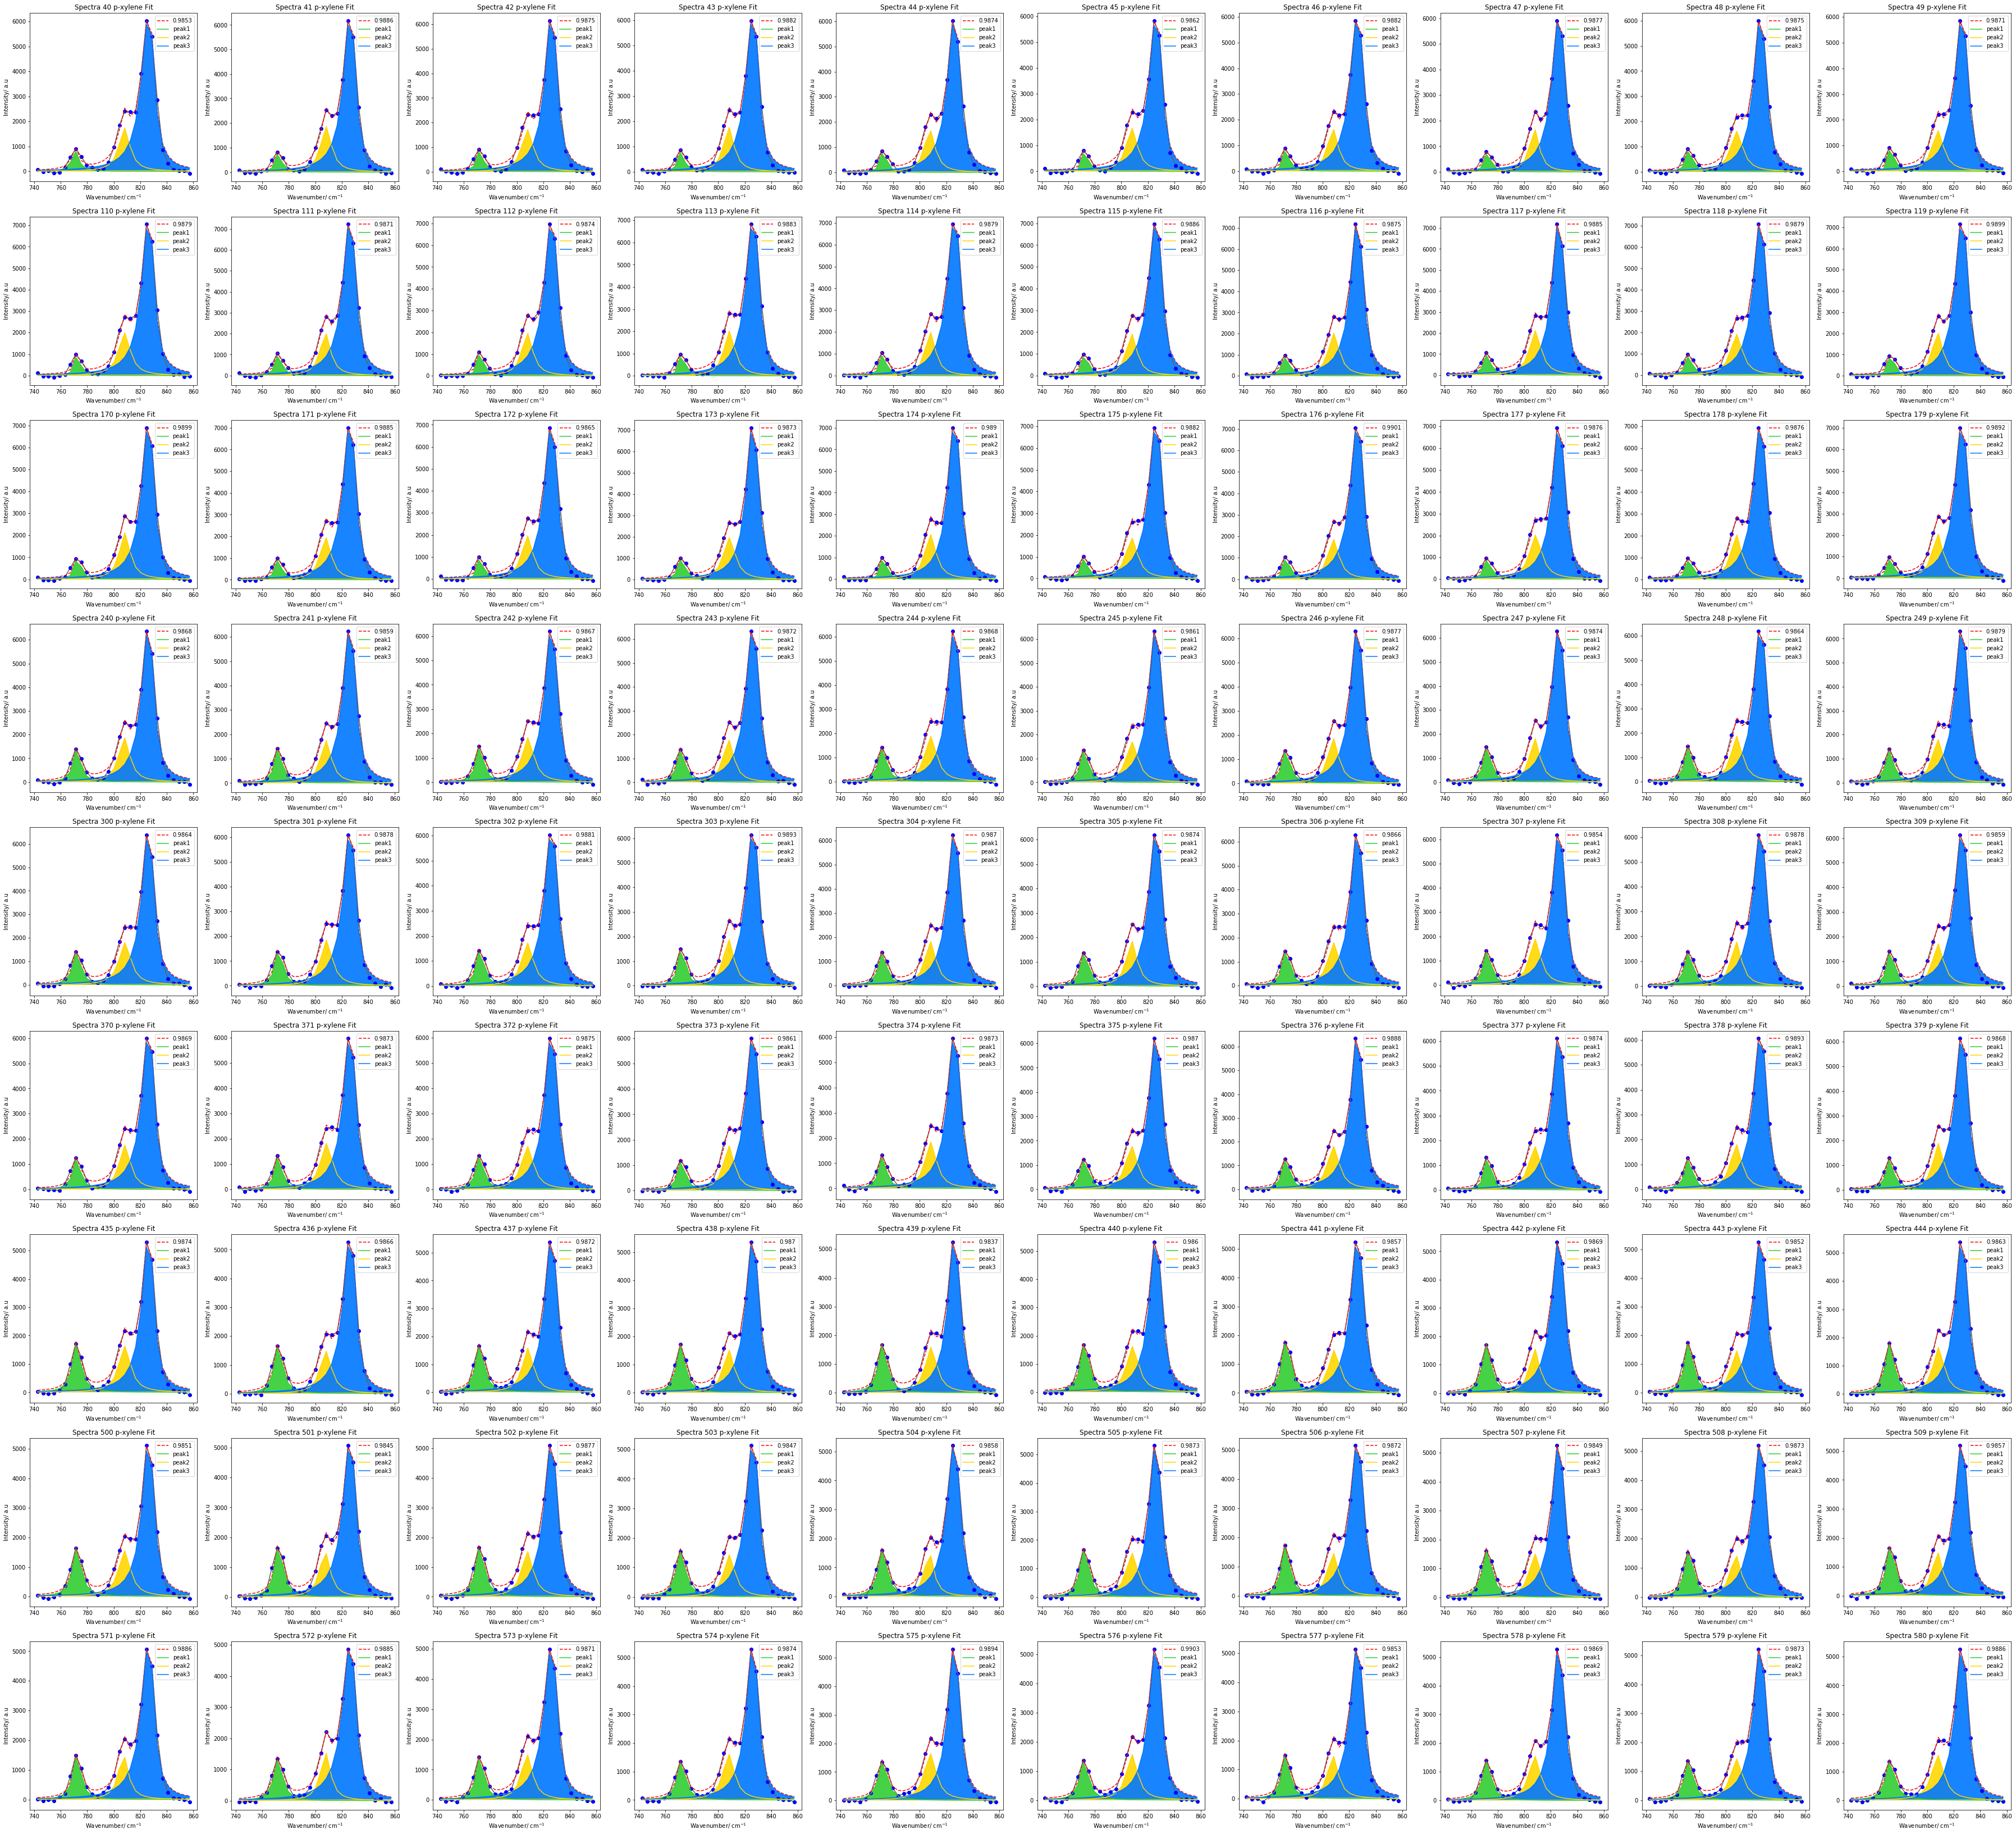

In [24]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])
Area_3 = collections.deque([])

pbar = tqdm(total = len(df_pxyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='ampL3', value = ampL3, min = 0)
pfit.add(name='cenL1', value = cenL1, min = 770, max = 780)
pfit.add(name='cenL2', value = cenL2, min = 805, max = 815)
pfit.add(name='cenL3', value = cenL3, min = 820, max = 830)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)
pfit.add(name='widL3', value = widL3, min = 0)
pfit.add(name='widL4', value = widL4, min = 0)

for i,item in df_pxyl.iterrows():
    
    x = df_pxyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:5].values.tolist():
        xbl.append(items)

    for items in y.index[25:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:5].tolist():
        ybl.append(items)

    for items in y.values[25:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['FWHM_L3'] = out.params.valuesdict()['widL3'] + out.params.valuesdict()['widL4']
    fit_params['Height_L1'] = 0.318309886*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.318309886*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    fit_params['Height_L3'] = 0.318309886*out.params.valuesdict()['ampL3']/max(2.220446049250313e-16, out.params.valuesdict()['widL3']+out.params.valuesdict()['widL4'])
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    peak3 = split_lorentzian(x,out.params.valuesdict()['ampL3'], out.params.valuesdict()['cenL3'], out.params.valuesdict()['widL3'], out.params.valuesdict()['widL4'])
    
    plt.subplot(np.ceil(np.sqrt(df_pxyl.shape[0])),np.ceil(np.sqrt(df_pxyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' p-xylene Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.plot(x, peak3,'#0077FF', label = 'peak3')
    plt.fill_between(x, peak3.min(), peak3, facecolor = '#0077FF', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    Area_3.append(integrate.simps(peak3, x))
    
    pbar.update(1)
    
plt.tight_layout()
plt.show()

In [25]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_pxyl'}, inplace=True)
results.describe()

ampL1         ampL2          ampL3       cenL1       cenL2  \
count     90.000000     90.000000      90.000000   90.000000   90.000000   
mean   14398.958617  28030.556142  110457.667044  772.361260  807.999877   
std     4759.794725   3324.464488   13086.920994    0.348045    0.304769   
min     6971.203200  20366.714802   89781.371829  770.964069  807.049798   
25%     9093.350575  25899.674957   96833.157812  772.164812  807.867697   
50%    15574.015848  28271.316971  111614.826232  772.329622  807.989350   
75%    17258.798654  30547.702536  116969.085075  772.564555  808.212112   
max    22381.341820  35374.282783  134902.004926  773.093002  808.651184   

            cenL3      widL1      widL2      widL3      widL4    R2_pxyl  \
count   90.000000  90.000000  90.000000  90.000000  90.000000  90.000000   
mean   826.775888   3.257782   5.102965   6.709628   4.219226   0.987278   
std      0.117201   0.693470   0.278083   0.246085   0.093507   0.001281   
min    826.453199   1.031652   4.250371   6.194673   4.019706   0.983686   
25%    826.700416   2.753833   4.907733   6.534700   4.171810   0.986585   
50%    826.766435   3.465611   5.096103   6.732631   4.214984   0.987343   
75%    826.861301   3.777823   5.285876   6.865657   4.280722   0.987919   
max    827.001218   4.260465   5.571333   7.425098   4.478411   0.990256   

         FWHM_L1    FWHM_L2    FWHM_L3    Height_L1    Height_L2    Height_L3  
count  90.000000  90.000000  90.000000    90.000000    90.000000    90.000000  
mean    6.515563  10.205929  10.928854  1393.024874  1748.463204  3216.892584  
std     1.386941   0.556166   0.262586   294.470656   186.601751   370.546702  
min     2.063305   8.500741  10.376641   816.857387  1423.925486  2597.847482  
25%     5.507666   9.815465  10.729155  1232.734825  1574.807426  2818.369426  
50%     6.931221  10.192206  10.926917  1381.534110  1761.426267  3250.104216  
75%     7.555646  10.571751  11.118196  1543.823275  1874.604853  3381.722059  
max     8.520929  11.142667  11.641545  2648.069934  2121.835079  3869.521727

In [26]:
df_area = pd.concat([df_area, pd.Series(Area_3), results['R2_pxyl']], axis=1)
df_area.rename(columns={0: 'pxyl Peak Area'}, inplace=True)
df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0               40          1     86586.358961  0.971919   107911.734588   
1               41          1     87775.613248  0.970677   105201.783720   
2               42          1     91638.788868  0.967427   103705.872006   
3               43          1     87665.726179  0.969521   104544.406126   
4               44          1     85219.916455  0.968660   103215.238825   
..             ...        ...              ...       ...             ...   
85             576          9    132950.753385  0.983526    88819.076700   
86             577          9    133020.366627  0.983495    89497.673015   
87             578          9    133455.802634  0.982681    86749.315471   
88             579          9    130215.019477  0.983479    87763.508221   
89             580          9    130687.853043  0.985839    87290.268981   

     R2_pxyl  
0   0.985343  
1   0.988580  
2   0.987458  
3   0.988169  
4   0.987382  
..       ...  
85  0.990256  
86  0.985309  
87  0.986852  
88  0.987307  
89  0.988646  

[90 rows x 6 columns]

In [27]:
# Keep only columns with R2 values above a threshold.
df_area = df_area[(df_area['R2_Vinyl'] > 0.96) & (df_area['R2_pxyl'] > 0.96)]

# Normalization
df_area['Vinyl Divide pxyl'] =  df_area['Vinyl Peak Area'] / df_area['pxyl Peak Area']

df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0               40          1     86586.358961  0.971919   107911.734588   
1               41          1     87775.613248  0.970677   105201.783720   
2               42          1     91638.788868  0.967427   103705.872006   
3               43          1     87665.726179  0.969521   104544.406126   
4               44          1     85219.916455  0.968660   103215.238825   
..             ...        ...              ...       ...             ...   
85             576          9    132950.753385  0.983526    88819.076700   
86             577          9    133020.366627  0.983495    89497.673015   
87             578          9    133455.802634  0.982681    86749.315471   
88             579          9    130215.019477  0.983479    87763.508221   
89             580          9    130687.853043  0.985839    87290.268981   

     R2_pxyl  Vinyl Divide pxyl  
0   0.985343           0.802381  
1   0.988580           0.834355  
2   0.987458           0.883641  
3   0.988169           0.838550  
4   0.987382           0.825652  
..       ...                ...  
85  0.990256           1.496872  
86  0.985309           1.486300  
87  0.986852           1.538408  
88  0.987307           1.483703  
89  0.988646           1.497164  

[90 rows x 7 columns]

In [28]:
# View the summary statistics
df_area_stats = df_area[['Condition', 'Vinyl Divide pxyl']].groupby('Condition').describe()
df_area_stats

Vinyl Divide pxyl                                                    \
                      count      mean       std       min       25%       50%   
Condition                                                                       
1                      10.0  0.834292  0.025710  0.800157  0.822147  0.830004   
2                      10.0  0.807316  0.027491  0.776274  0.791694  0.798520   
3                      10.0  0.801188  0.012983  0.789335  0.792801  0.796006   
4                      10.0  1.252507  0.025390  1.217290  1.236531  1.252324   
5                      10.0  1.274837  0.026955  1.236738  1.256904  1.270929   
6                      10.0  1.173810  0.027581  1.134492  1.158291  1.167820   
7                      10.0  1.759394  0.038226  1.716233  1.734840  1.744325   
8                      10.0  1.765569  0.052740  1.684603  1.737251  1.762952   
9                      10.0  1.506035  0.030100  1.470236  1.484423  1.497018   

                               
                75%       max  
Condition                      
1          0.850419  0.883641  
2          0.821077  0.862056  
3          0.806370  0.830607  
4          1.267071  1.291285  
5          1.298918  1.313150  
6          1.199491  1.212239  
7          1.783378  1.837208  
8          1.789252  1.867069  
9          1.522223  1.568069

In [29]:
mean = df_area_stats['Vinyl Divide pxyl', 'mean'].values
std = df_area_stats['Vinyl Divide pxyl', 'std'].values
condition = range(1,10)

In [30]:
df_ratio = pd.DataFrame({'Condition':condition, 'Mean Ratio':mean, 'Standard Deviation': std})
df_ratio

Condition  Mean Ratio  Standard Deviation
0          1    0.834292            0.025710
1          2    0.807316            0.027491
2          3    0.801188            0.012983
3          4    1.252507            0.025390
4          5    1.274837            0.026955
5          6    1.173810            0.027581
6          7    1.759394            0.038226
7          8    1.765569            0.052740
8          9    1.506035            0.030100

In [31]:
df_ratio.to_csv(r'C:\Users\Tan Jin Da\Desktop\High Throughput Experiments Data\201008 High Throughput Experiment Conditions 1 to 9\Online Raman\df_t60_ratio.csv')